In [5]:
# EDA.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv(r"E:\Code Space\churn_prediction_mlops\data\raw\data2.csv")
df.head()


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [6]:
df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


date_of_last_rech_data_6    74846
total_rech_data_6           74846
max_rech_data_6             74846
count_rech_2g_6             74846
av_rech_amt_data_6          74846
count_rech_3g_6             74846
arpu_3g_6                   74846
arpu_2g_6                   74846
fb_user_6                   74846
night_pck_user_6            74846
dtype: int64

In [15]:
# A customer is churned if they have zero revenue in month 9
df['churn'] = df['arpu_9'].apply(lambda x: 1 if x == 0 else 0)

print(df['churn'].value_counts(normalize=True))


churn
0    0.909309
1    0.090691
Name: proportion, dtype: float64


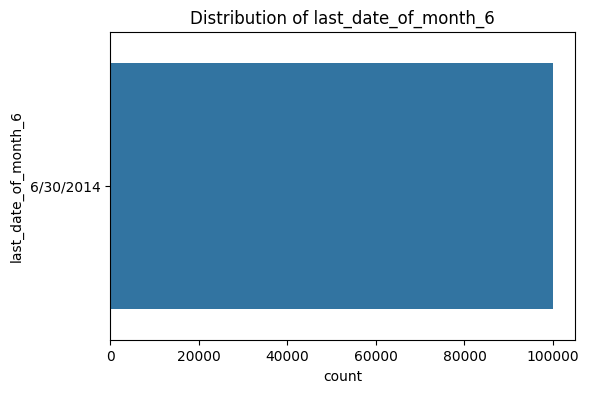

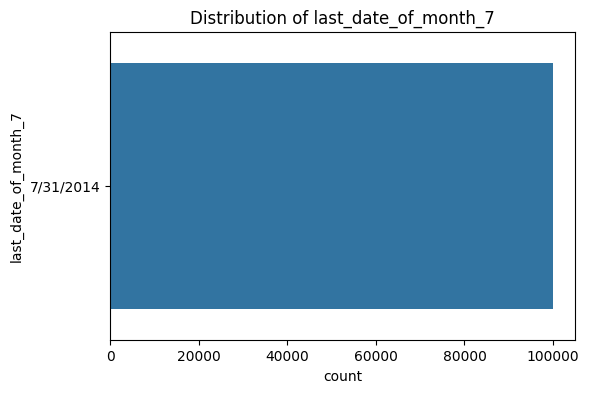

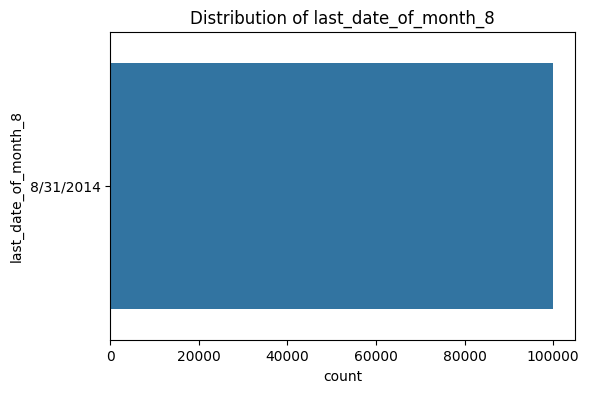

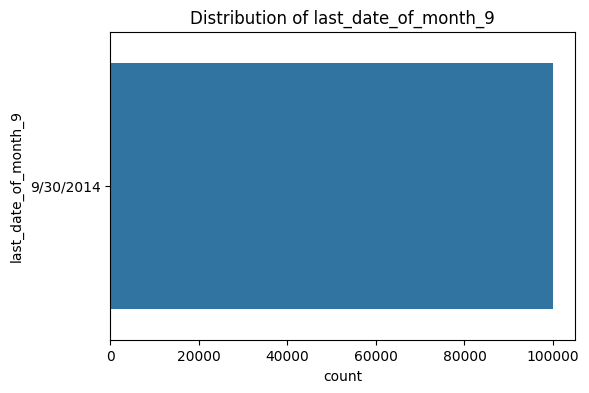

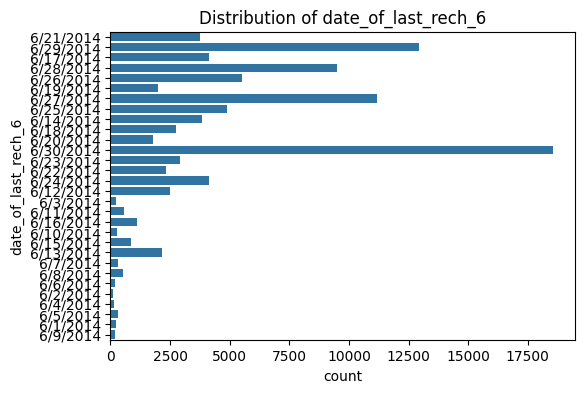

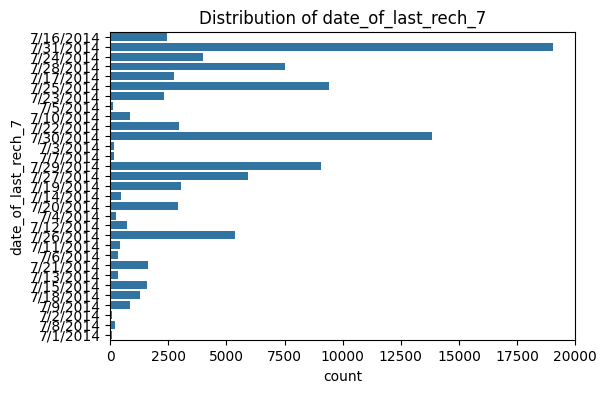

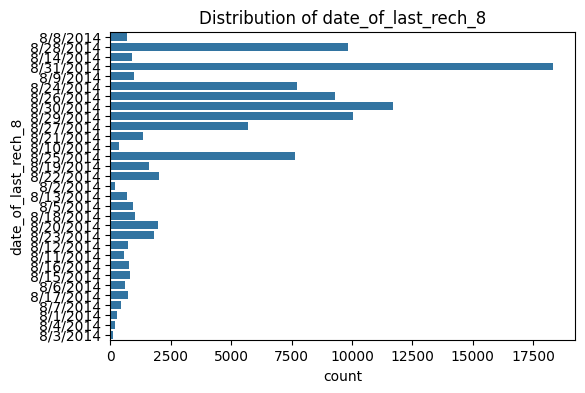

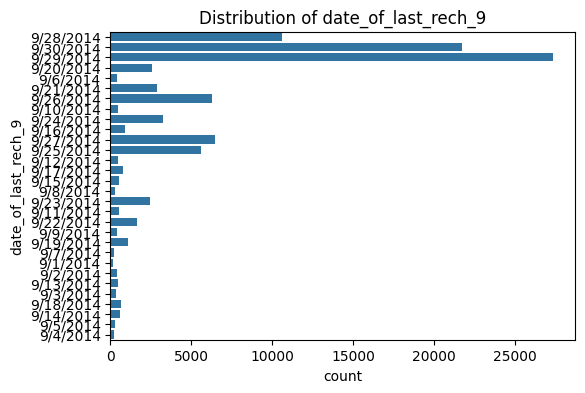

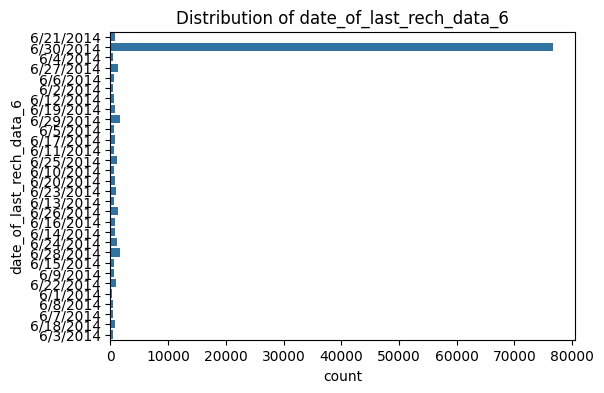

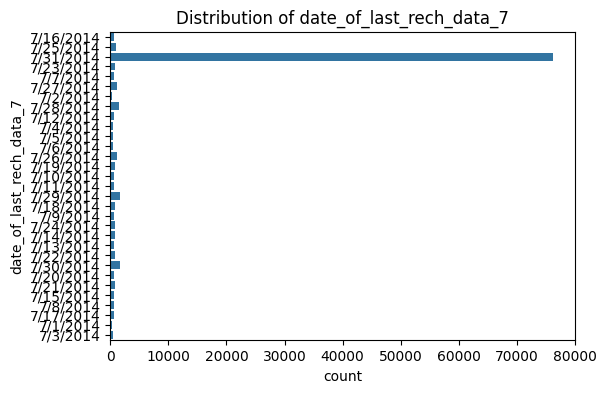

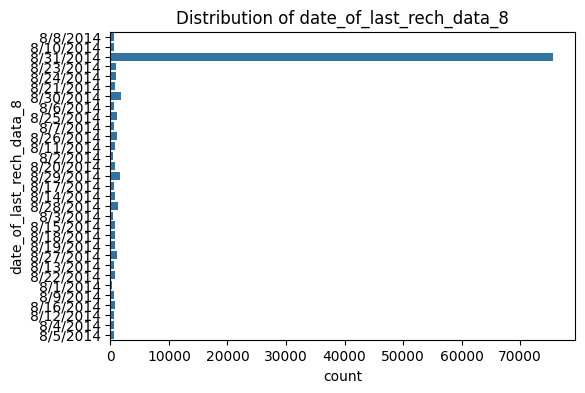

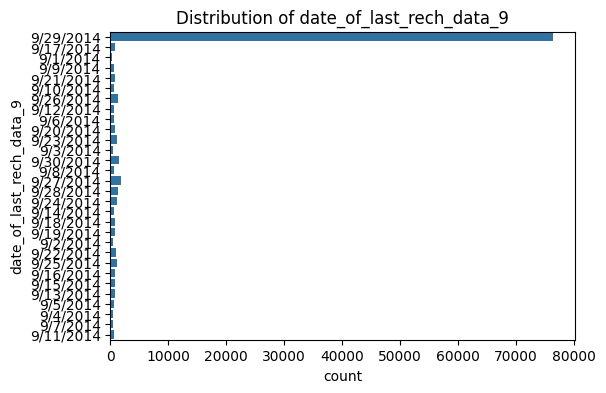

In [16]:
## Categorial Distribution

categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.show()


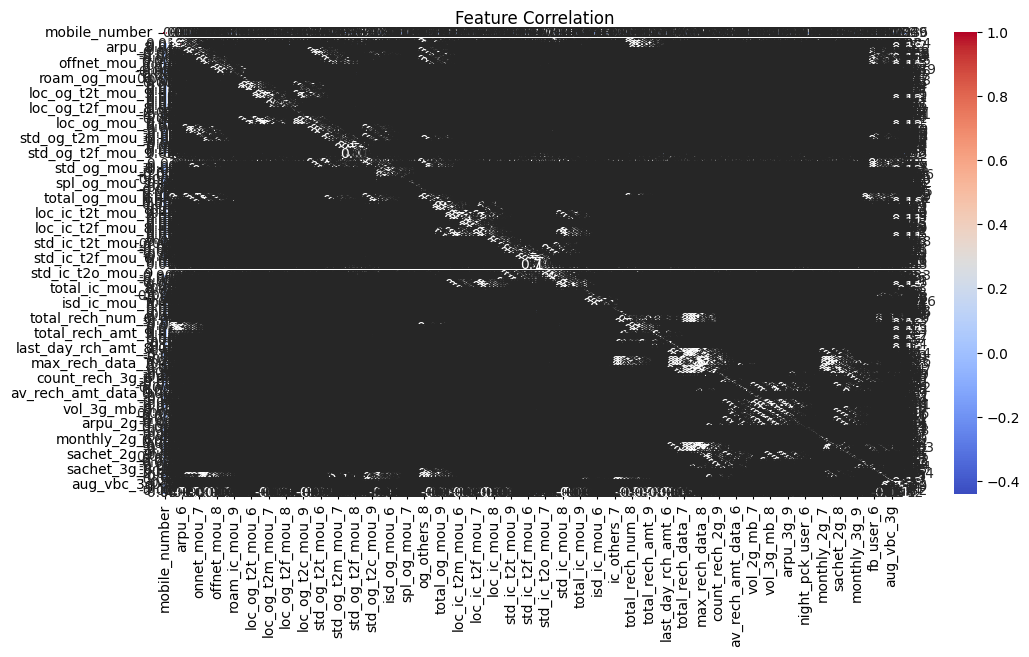

In [17]:
## Correlation Heatmap

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


In [21]:
print(df["churn"])

0        0
1        0
2        0
3        0
4        0
        ..
99994    0
99995    0
99996    1
99997    0
99998    1
Name: churn, Length: 99999, dtype: int64


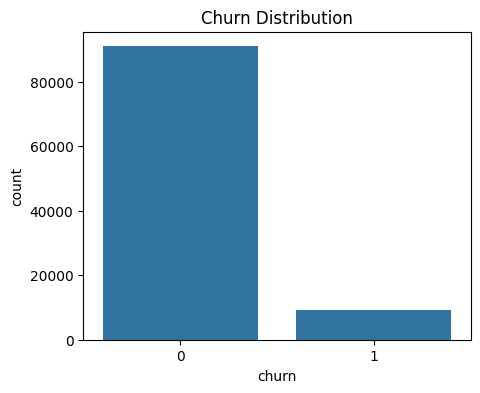

In [22]:
## Chrurn Distribution

plt.figure(figsize=(5,4))
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")
plt.show()


In [23]:
df.isnull().sum()


mobile_number     0
circle_id         0
loc_og_t2o_mou    0
std_og_t2o_mou    0
loc_ic_t2o_mou    0
                 ..
aug_vbc_3g        0
jul_vbc_3g        0
jun_vbc_3g        0
sep_vbc_3g        0
churn             0
Length: 227, dtype: int64

In [24]:
df.fillna(df.median(numeric_only=True), inplace=True)


In [25]:
df.fillna(df.mode().iloc[0], inplace=True)


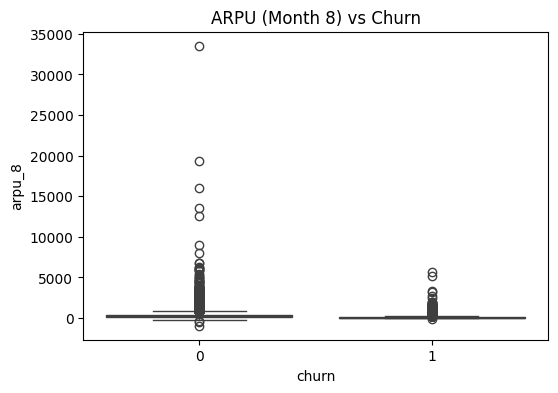

In [27]:
## Feature impact
plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='arpu_8', data=df)
plt.title("ARPU (Month 8) vs Churn")
plt.show()

In [28]:
## Data cleaning

# Drop columns with too many missing values (e.g. >70%)
threshold = 0.7 * df.shape[0]
df = df.dropna(thresh=threshold, axis=1)

# Fill remaining missing numeric values with 0
df.fillna(0, inplace=True)

# Drop ID or date columns (non-predictive)
drop_cols = [c for c in df.columns if 'date' in c or 'mobile_number' in c]
df.drop(columns=drop_cols, inplace=True)


In [29]:
# Average revenue across months 6-8
df['avg_arpu'] = df[['arpu_6', 'arpu_7', 'arpu_8']].mean(axis=1)

# Average outgoing calls
df['avg_loc_og_mou'] = df[['loc_og_t2o_mou', 'std_og_t2o_mou']].mean(axis=1)

# Change in ARPU month-over-month
df['arpu_change'] = df['arpu_8'] - df['arpu_6']


In [30]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [31]:
# Create churn label
df['churn'] = df['arpu_9'].apply(lambda x: 1 if x == 0 else 0)

# Drop identifiers & non-predictive columns
drop_cols = [c for c in df.columns if 'date' in c or 'mobile_number' in c]
df.drop(columns=drop_cols, inplace=True)

# Drop columns with >70% missing values
threshold = 0.7 * df.shape[0]
df = df.dropna(thresh=threshold, axis=1)

# Fill remaining missing numeric values with 0
df.fillna(0, inplace=True)

print(f"Shape after cleaning: {df.shape}")
df.head()

Shape after cleaning: (99999, 217)


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn,avg_arpu,avg_loc_og_mou,arpu_change
0,109,0.0,0.0,0.0,197.385,214.816,213.803,21.100,34.31,32.33,...,1.0,968,30.4,0.0,101.20,3.58,0,208.668000,0.0,16.418
1,109,0.0,0.0,0.0,34.047,355.074,268.321,86.285,24.11,78.68,...,1.0,1006,0.0,0.0,0.00,0.00,0,219.147333,0.0,234.274
2,109,0.0,0.0,0.0,167.690,189.058,210.226,290.714,11.54,55.24,...,1.0,1103,0.0,0.0,4.17,0.00,0,188.991333,0.0,42.536
3,109,0.0,0.0,0.0,221.338,251.102,508.054,389.500,99.91,54.39,...,1.0,2491,0.0,0.0,0.00,0.00,0,326.831333,0.0,286.716
4,109,0.0,0.0,0.0,261.636,309.876,238.174,163.426,50.31,149.44,...,1.0,1526,0.0,0.0,0.00,0.00,0,269.895333,0.0,-23.462


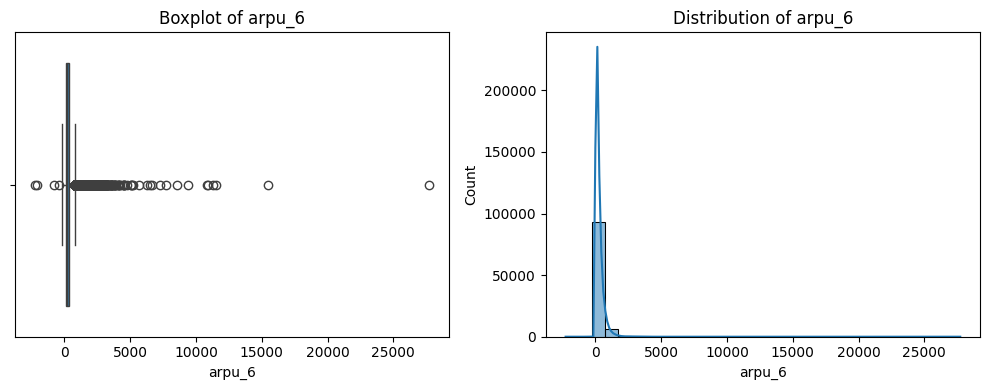

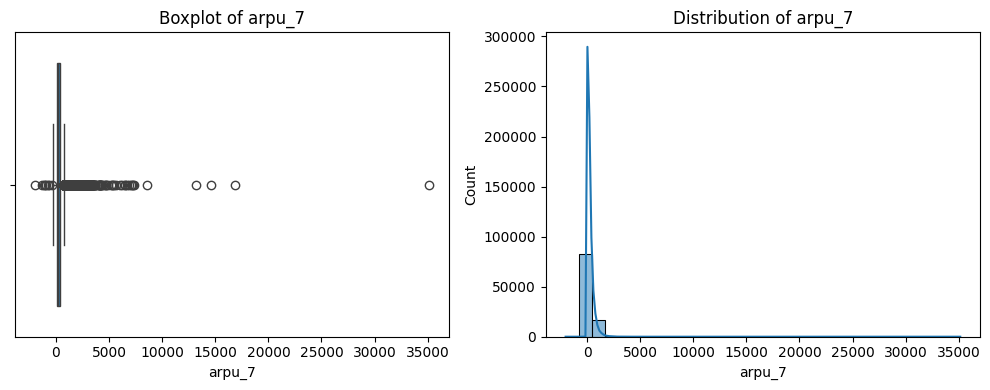

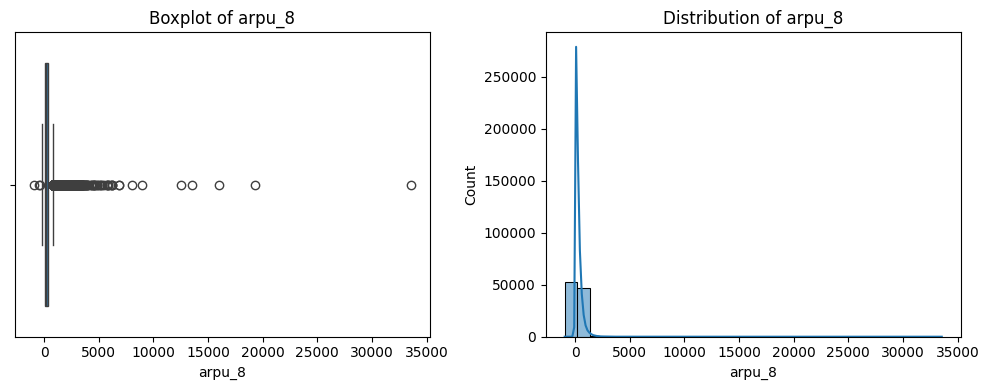

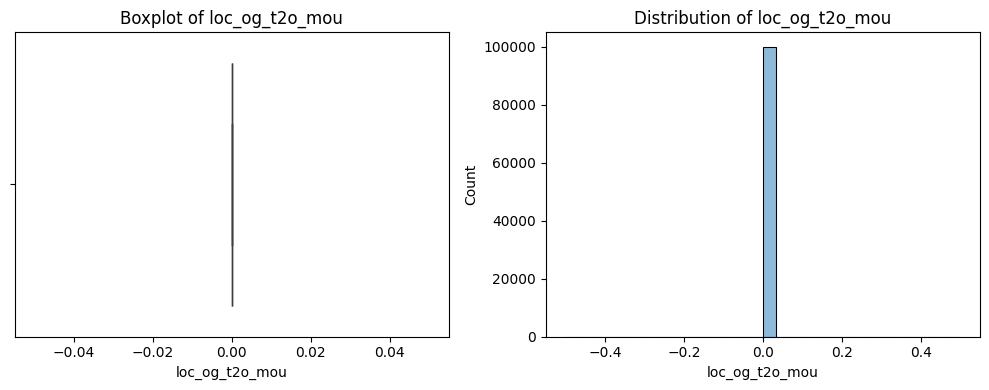

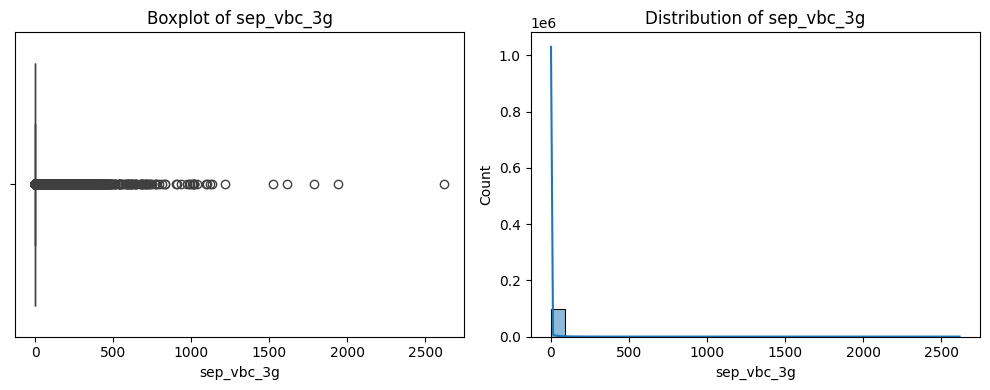

In [32]:
features = ['arpu_6', 'arpu_7', 'arpu_8', 'loc_og_t2o_mou', 'sep_vbc_3g']

for col in features:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

    plt.subplot(1,2,2)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

In [34]:
import numpy as np 

def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

for col in features:
    df = cap_outliers(df, col)


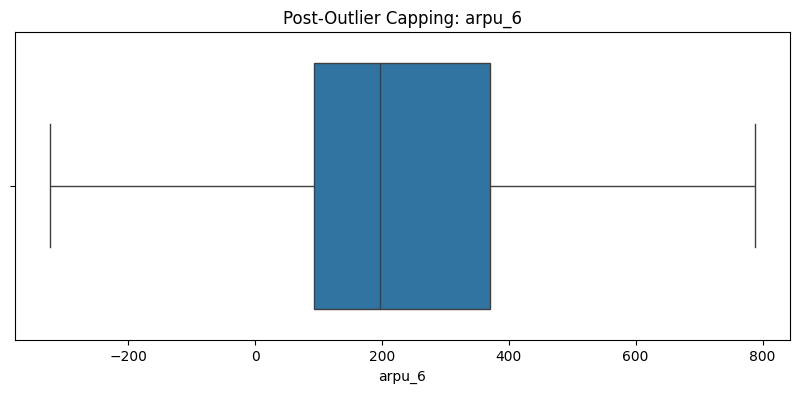

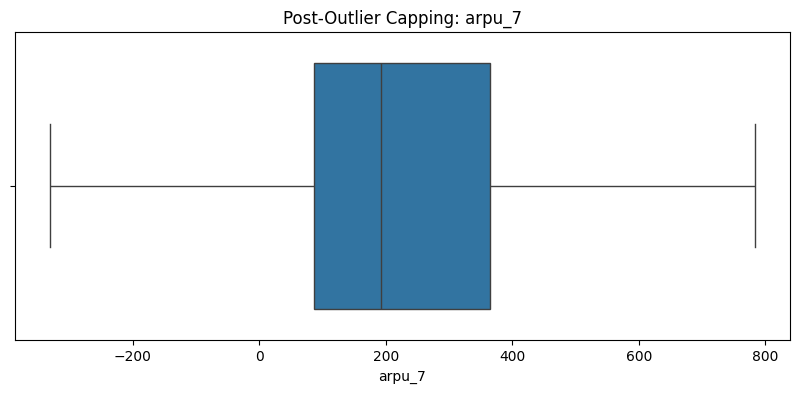

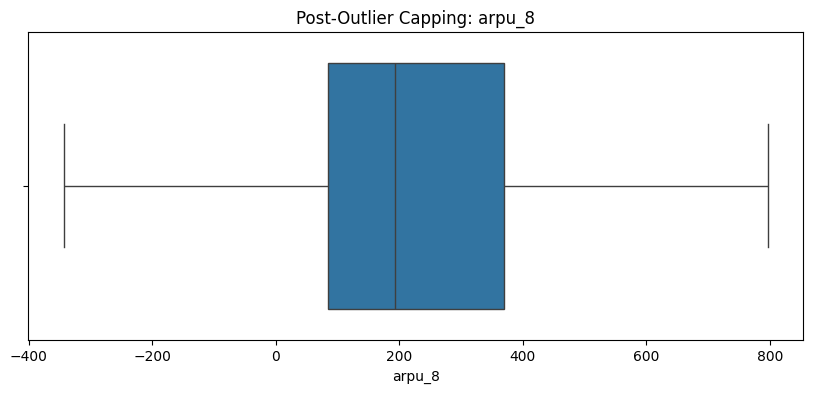

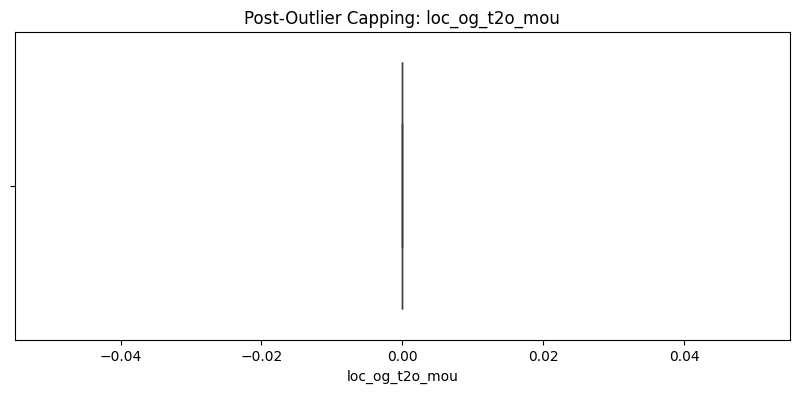

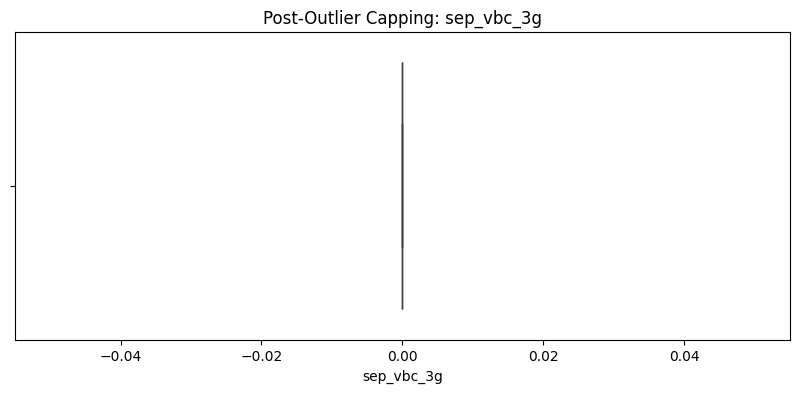

In [35]:
for col in features:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df[col])
    plt.title(f"Post-Outlier Capping: {col}")
    plt.show()


In [36]:
skewed_cols = ['arpu_6', 'arpu_7', 'arpu_8', 'sep_vbc_3g']
for col in skewed_cols:
    df[col] = np.log1p(df[col])  # log(1 + x)


e:\Code Space\churn_prediction_mlops\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
e:\Code Space\churn_prediction_mlops\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


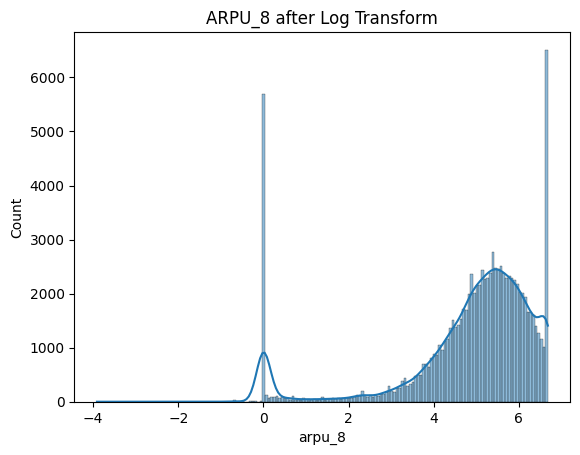

In [37]:
sns.histplot(df['arpu_8'], kde=True)
plt.title("ARPU_8 after Log Transform")
plt.show()


In [39]:
import numpy as np

print("Any NaN:", np.isnan(df[features]).any().any())
print("Any inf:", np.isinf(df[features]).any().any())
print("Max value:", df[features].max().max())



Any NaN: True
Any inf: True
Max value: 6.682405859027619


In [40]:
# Replace infinite or NaN values
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
df[features] = df[features].fillna(0)


In [41]:
for col in features:
    upper_limit = df[col].quantile(0.99)
    df[col] = np.clip(df[col], 0, upper_limit)


In [42]:
df[col] = np.log1p(df[col])


In [43]:
for col in features:
    df[col] = np.where(df[col] < 0, 0, df[col])  # avoid log(negative)


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

print("✅ Scaling successful!")


✅ Scaling successful!


In [45]:
df_scaled = df.copy()
df_scaled[features] = X_scaled
df_scaled.head()


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn,avg_arpu,avg_loc_og_mou,arpu_change
0,109,0.0,0.0,0.0,0.208615,0.288053,0.308441,21.100,34.31,32.33,...,1.0,968,30.4,0.0,101.20,0.0,0,208.668000,0.0,16.418
1,109,0.0,0.0,0.0,-0.957935,0.620554,0.445067,86.285,24.11,78.68,...,1.0,1006,0.0,0.0,0.00,0.0,0,219.147333,0.0,234.274
2,109,0.0,0.0,0.0,0.099500,0.203653,0.298297,290.714,11.54,55.24,...,1.0,1103,0.0,0.0,4.17,0.0,0,188.991333,0.0,42.536
3,109,0.0,0.0,0.0,0.285323,0.391252,0.829636,389.500,99.91,54.39,...,1.0,2491,0.0,0.0,0.00,0.0,0,326.831333,0.0,286.716
4,109,0.0,0.0,0.0,0.397414,0.530412,0.373358,163.426,50.31,149.44,...,1.0,1526,0.0,0.0,0.00,0.0,0,269.895333,0.0,-23.462


In [46]:
df_scaled.to_csv(r"E:\Code Space\churn_prediction_mlops\data\processed\telecom_churn_scaled.csv", index=False)

